In [43]:
using Gumbo
using Cascadia
using DataFrames
using JuMP
using HiGHS
using CSV
using Plots

In [44]:
# import timeseries data 
antares_df = DataFrame(CSV.File("2030_residual_demand_ts.csv"))
antares_df[!, :residual_2] = antares_df[!, :LOAD] - antares_df[!, :WIND] - antares_df[!, :SOLAR]
antares_df

Row,INDEX,LOAD,WIND,SOLAR,RESIDUAL,SOC,residual_2
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,43.126,73.933,0.0,-30.807,30.807,-30.807
2,2,41.347,74.403,0.0,-33.056,63.863,-33.056
3,3,39.491,74.846,0.0,-35.355,99.218,-35.355
4,4,43.22,74.976,0.0,-31.756,130.974,-31.756
5,5,48.505,74.894,0.0,-26.389,157.363,-26.389
6,6,50.44,73.747,0.0,-23.307,180.67,-23.307
7,7,51.623,72.931,0.499,-21.807,202.477,-21.807
8,8,52.399,71.349,3.186,-22.136,224.613,-22.136
9,9,53.419,69.958,5.988,-22.527,247.14,-22.527


In [45]:
# total energy volumes in each column
sum.(eachcol(antares_df))

7-element Vector{Real}:
 38137011
   391520.16799999995
   320500.92799999996
    41151.971000000005
    29867.269
       -8.9570948928e7
    29867.269

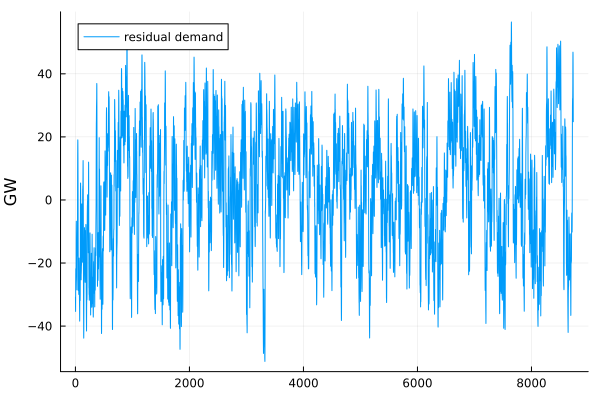

In [46]:
# plot residual demand over time
plot(antares_df[!, :residual_2], label="residual demand", ylabel="GW")

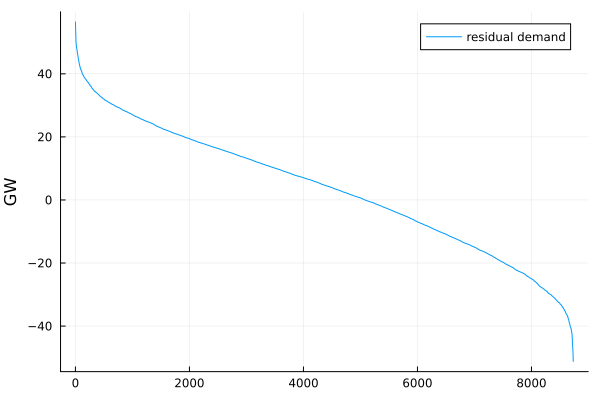

In [47]:
# residual demand duration curve
plot(sort(antares_df[!, :residual_2], rev=true), label="residual demand", ylabel="GW")

In [48]:
# total negative energy (=energy that can be stored)
total_excess = sum(filter(:residual_2 => n -> n<0, antares_df)[!, :residual_2])
total_excess

-56912.57800000001

In [49]:
# calculate cumulative volumes of energy not met at top end of duration curve 
sorted_residual_df = sort(antares_df[!, [:residual_2]], rev=true)
sorted_residual_df = transform(sorted_residual_df, :residual_2 => ByRow(x -> maximum(sorted_residual_df[!, :residual_2])-x) => :excess_vol)
sorted_residual_df[!, :cum_excess_vol] = cumsum(sorted_residual_df[!, :excess_vol])
sorted_residual_df

Row,residual_2,excess_vol,cum_excess_vol
,Float64,Float64,Float64
1,56.434,0.0,0.0
2,55.659,0.775,0.775
3,54.736,1.698,2.473
4,54.413,2.021,4.494
5,53.55,2.884,7.378
6,52.81,3.624,11.002
7,52.39,4.044,15.046
8,51.523,4.911,19.957
9,50.366,6.068,26.025


In [50]:
# find positive residual volume that matches negative energy
adequacy_level = last(filter(:cum_excess_vol => n -> n<total_excess*-1, sorted_residual_df)[!, :residual_2])
adequacy_level

19.289000000000005

In [51]:
# determine state of charge of theoretical battery
# assume it stores all negative residual demand
# and exports whenever residual demand is above adequacy level
# (assumes 100% round trip efficiency and battery can go into negative SoC as long as total balance is met)
antares_df = transform(antares_df, :residual_2 => ByRow(x -> x*!((x>0)&&(x<=adequacy_level))) => :storage_vol)
antares_df[!, :storage_soc] = cumsum(antares_df[!, :storage_vol])
antares_df


Row,INDEX,LOAD,WIND,SOLAR,RESIDUAL,SOC,residual_2,storage_vol,storage_soc
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,43.126,73.933,0.0,-30.807,30.807,-30.807,-30.807,-30.807
2,2,41.347,74.403,0.0,-33.056,63.863,-33.056,-33.056,-63.863
3,3,39.491,74.846,0.0,-35.355,99.218,-35.355,-35.355,-99.218
4,4,43.22,74.976,0.0,-31.756,130.974,-31.756,-31.756,-130.974
5,5,48.505,74.894,0.0,-26.389,157.363,-26.389,-26.389,-157.363
6,6,50.44,73.747,0.0,-23.307,180.67,-23.307,-23.307,-180.67
7,7,51.623,72.931,0.499,-21.807,202.477,-21.807,-21.807,-202.477
8,8,52.399,71.349,3.186,-22.136,224.613,-22.136,-22.136,-224.613
9,9,53.419,69.958,5.988,-22.527,247.14,-22.527,-22.527,-247.14


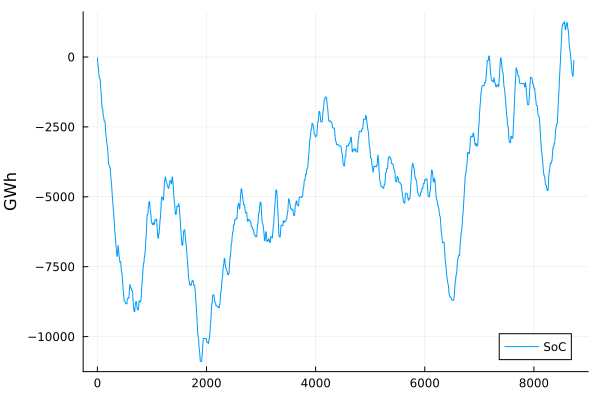

In [52]:
# state of charge of theoretical magical battery
plot(antares_df[!, :storage_soc], label="SoC", ylabel="GWh")

In [53]:
function ThermalGenerator(
    min::Float64,
    max::Float64,
    fixed_cost::Float64,
    variable_cost::Float64,
)
    return (
        min = min,
        max = max,
        fixed_cost = fixed_cost,
        variable_cost = variable_cost,
    )
end

generators = [
    ThermalGenerator(0.0, 1000.0, 1000.0, 50.0),
]

1-element Vector{NamedTuple{(:min, :max, :fixed_cost, :variable_cost), NTuple{4, Float64}}}:
 (min = 0.0, max = 1000.0, fixed_cost = 1000.0, variable_cost = 50.0)

In [54]:
model = Model(HiGHS.Optimizer)

# list of all thermal generators
N = length(generators)
@variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max) # power output of thermal generation in a particular timestep

# wind power injection
@variable(model, 0 <= w <= scenario.wind)




UndefVarError: UndefVarError: scenario not defined